# Exploration of provided code 
### by Adam Rychert


Find attached the dataset for the project. The data contains measurements taken from a charging point, which is composed by:

A Solar Panel Installation
A local battery
A connection to the grid
8 e-charging wallboxes
 

SUMMARY OF THE PROJECT:

The e-charging requests (from cars) are served with energy coming from the PV, the local battery, and/or the external grid. The system is programmed to avoid that the power drawn from the external grid exceeds the value of a threshold (“DEMAND_LIMIT”). This is known as peak-shaving, e.g., when the power drawn from the grid exceeds the DEMAND_LIMIT threshold, the local battery starts being used providing energy to “shave the peak”. Obviously, this cannot happen always and sometimes the threshold is violated (e.g., when several cars are attached, and the local battery has a low state of charge). In the data you can see when and how often this happens.

 

The goal of the project is to perform “knowledge-base completion” and rule learning, possibly with neuro-symbolic approaches.

 

For ground truth, at the moment the following rules are applied for the behavior of the local battery, based on its State-Of-Charge (SOC):

SOC > 80%: e-cars charging is completely covered by the local battery
40% < SOC < 80%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
SOC < 40%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
SOC < 15%: Battery discharging is stopped due to battery health
 

Research Questions:

If the values above are not specified, can we learn them? E.g. with Hybrid AI / Neuro-symbolic approaches? (knowledge base completion with LNN?)
Are there other rules in the microgrid, that can be learned from the data?
Once the rules are learned and the values above are found (e.g., 15%, 40%, 80% thresholds), is it possible to find better values, e.g., that minimize the risk of violating the DEMAND_LIMIT?
One potential idea is to specify the rules in term of logic formula and learn/complete/optimize them with Neuro-symbolic AI.

## Load libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

## Load data

In [3]:
# load the data 
ds_dynamic = pd.read_csv('..\data\Stud_E-mobility_data_dynamicLimit.csv')
ds_static = pd.read_csv('..\data\Stud_E-mobility_data_staticLimit.csv')

## Exploration

In [4]:
ds_dynamic.shape, ds_static.shape

((121351, 26), (59442, 26))

In [5]:
ds_dynamic.head()

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,WALLBOX_ALPHA_POWER,WALLBOX_1_ENERGY,WALLBOX_1_POWER,WALLBOX_2_ENERGY,WALLBOX_2_POWER,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-11-23 00:00:00+00:00,25.552753,86.0,2.0,40.5,-0.227,0.0,0.0,0.003358,0.0,0.001953,0.013827,0.0,0.002951,0.000000,0.003734,0.070312,3.650522,0.0,0.010353,0.187500,10.474393,0.177734,10.343011,0.000000,0.150391
1,2023-11-23 00:01:00+00:00,25.744160,86.0,2.0,40.5,-0.232,0.0,0.0,0.003509,0.0,0.000000,0.013525,0.0,0.002951,0.000000,0.003734,0.058594,3.680303,0.0,0.010353,0.175781,10.573653,0.175781,10.442042,0.000000,0.149357
2,2023-11-23 00:02:00+00:00,24.691425,86.0,2.0,40.5,-0.266,0.0,0.0,0.003895,0.0,0.000000,0.013453,0.0,0.002797,0.000000,0.003734,0.058594,3.681628,0.0,0.010353,0.150391,10.573653,0.162109,9.434032,0.007812,0.148999
3,2023-11-23 00:03:00+00:00,24.882832,85.0,2.0,40.5,-0.191,0.0,0.0,0.003756,0.0,0.000000,0.013551,0.0,0.002797,0.000977,0.003734,0.058594,3.686006,0.0,0.010353,0.203125,10.573653,0.156250,9.434032,0.000000,0.149066
4,2023-11-23 00:04:00+00:00,25.457050,85.0,2.0,40.5,-0.256,0.0,0.0,0.003411,0.0,0.000000,0.014334,0.0,0.002928,0.000000,0.003734,0.070312,3.620064,0.0,0.010353,0.173828,10.499119,0.166016,10.307555,0.000000,0.148739


In [6]:
ds_static.head()

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,WALLBOX_ALPHA_POWER,WALLBOX_1_ENERGY,WALLBOX_1_POWER,WALLBOX_2_ENERGY,WALLBOX_2_POWER,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-10-05 00:01:00+00:00,1.244171,50.0,1.0,40.5,-0.338,0.0,0.0,0.008693,0.0,0.0,0.014348,0.0,0.000323,0.000000,0.000563,0.0,0.006914,0.000000,0.010233,0.000000,0.010435,0.0,0.010112,0.000000,0.154965
1,2023-10-05 00:02:00+00:00,1.244171,50.0,1.0,40.5,-0.372,0.0,0.0,0.008693,0.0,0.0,0.014633,0.0,0.000497,0.000977,0.000563,0.0,0.007550,0.000977,0.010233,0.000000,0.010435,0.0,0.010112,0.007812,0.155586
2,2023-10-05 00:03:00+00:00,1.244171,50.0,1.0,40.5,-0.393,0.0,0.0,0.008693,0.0,0.0,0.015053,0.0,0.000421,0.000000,0.000563,0.0,0.006996,0.000000,0.010233,0.000000,0.010435,0.0,0.010112,0.000000,0.157340
3,2023-10-05 00:04:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.0,0.0,0.008693,0.0,0.0,0.014739,0.0,0.000350,0.000000,0.000563,0.0,0.007392,0.000000,0.010233,0.000977,0.010435,0.0,0.010112,0.000000,0.158009
4,2023-10-05 00:05:00+00:00,1.244171,50.0,1.0,40.5,-0.371,0.0,0.0,0.008693,0.0,0.0,0.014626,0.0,0.000350,0.000000,0.000563,0.0,0.007188,0.000000,0.010233,0.000000,0.010435,0.0,0.010112,0.007812,0.158804


In [7]:
ds_dynamic.columns

Index(['_time', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER'],
      dtype='object')

peak-shaving, e.g., when the power drawn from the grid exceeds the DEMAND_LIMIT threshold, the local battery starts being used providing energy to “shave the peak”.

### Features desc
- GARAGE_EXTERNAL_POWER - power drawns from external grid [kW]
- DEMAND_LIMIT - limit which should not be exceeded by GARAGE_EXTERNAL_POWER [kW]
- DEMAND_LIMIT_INDICATOR -  1: Static limit, 2: Dynamic limit
- BATTERY_SOC - State of charge - bettery power level

Battery
- BATTERY_DISCHARGE_POWER
- BATTERY_CHARGED_ENERGY
- BATTERY_DISCHARGED_ENERGY

Solar Panel
- PV_POWER
- PV_ENERGY

8 e-charging wallboxes
- 'WALLBOX_ALPHA_ENERGY', WALLBOX_ALPHA_POWER',
- 'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER',
- 'WALLBOX_2_ENERGY','WALLBOX_2_POWER',
- 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
- 'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 
- 'WALLBOX_B_ENERGY','WALLBOX_B_POWER', 
- 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
- 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER'


In [8]:
ds_dynamic.columns == ds_static.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [9]:
ds_dynamic.dtypes

_time                          object
GARAGE_EXTERNAL_POWER         float64
DEMAND_LIMIT                  float64
DEMAND_LIMIT_INDICATOR        float64
BATTERY_SOC                   float64
BATTERY_DISCHARGE_POWER       float64
BATTERY_CHARGED_ENERGY        float64
BATTERY_DISCHARGED_ENERGY     float64
PV_POWER                      float64
PV_ENERGY                     float64
WALLBOX_ALPHA_ENERGY          float64
WALLBOX_ALPHA_POWER           float64
WALLBOX_1_ENERGY              float64
WALLBOX_1_POWER               float64
WALLBOX_2_ENERGY              float64
WALLBOX_2_POWER               float64
WALLBOX_3_ENERGY              float64
WALLBOX_3_POWER               float64
WALLBOX_A_ENERGY              float64
WALLBOX_A_POWER               float64
WALLBOX_B_ENERGY              float64
WALLBOX_B_POWER               float64
WALLBOX_C_ENERGY              float64
WALLBOX_C_POWER               float64
WALLBOX_FASTCHARGER_ENERGY    float64
WALLBOX_FASTCHARGER_POWER     float64
dtype: objec

In [10]:
ds_dynamic.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,WALLBOX_ALPHA_POWER,WALLBOX_1_ENERGY,WALLBOX_1_POWER,WALLBOX_2_ENERGY,WALLBOX_2_POWER,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
count,121351.000000,121351.00000,121351.0,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000,121351.000000
mean,16.454649,81.29849,2.0,44.725783,-0.318955,0.019060,0.013725,0.529543,0.008832,0.020681,1.241381,0.004884,0.292916,0.005727,0.342883,0.033592,2.015591,0.002391,0.151356,0.003487,0.217228,0.003608,0.224171,0.194609,11.671483
std,24.910673,9.36707,0.0,7.945003,7.066676,0.089736,0.075492,1.154890,0.019299,0.086757,5.220462,0.022561,1.354556,0.024976,1.501370,0.058631,3.518133,0.017467,1.045001,0.020692,1.238936,0.020117,1.205893,0.407542,24.491593
min,-30.337851,16.00000,2.0,21.000000,-63.165005,0.000000,0.000000,-0.068548,0.000000,0.000000,0.002209,0.000000,-0.005513,0.000000,-0.033036,0.000000,-0.009991,-0.017578,0.009658,-0.017578,0.009803,0.000000,0.009827,0.000000,0.000015
25%,1.052765,84.00000,2.0,40.500000,-0.373000,0.000000,0.000000,0.005922,0.000000,0.000000,0.014844,0.000000,0.000649,0.000000,0.000834,0.000000,0.006248,0.000000,0.009658,0.000000,0.009803,0.000000,0.009827,0.000000,0.146960
50%,4.498076,86.00000,2.0,41.000000,-0.247000,0.000000,0.000000,0.007725,0.000000,0.000000,0.015936,0.000000,0.001402,0.000000,0.001589,0.000000,0.007742,0.000000,0.009658,0.000000,0.009803,0.000000,0.009827,0.000000,0.157512
75%,16.460962,86.00000,2.0,47.000000,-0.215000,0.000000,0.000000,0.417880,0.007812,0.000000,0.016951,0.000000,0.003188,0.000000,0.003703,0.058594,3.612240,0.000000,0.009658,0.000000,0.009803,0.000000,0.009827,0.007812,0.170212
max,102.498032,86.00000,2.0,70.500000,73.592003,1.101562,1.296875,9.401698,0.304688,0.851562,31.702539,0.138672,7.792593,0.188477,10.894385,0.207031,11.784684,0.214844,12.272879,0.218750,11.574594,0.345703,21.056042,3.945312,80.978798


In [11]:
ds_static.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,WALLBOX_ALPHA_POWER,WALLBOX_1_ENERGY,WALLBOX_1_POWER,WALLBOX_2_ENERGY,WALLBOX_2_POWER,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,0.691316,0.007247,0.411108,0.005244,0.266099,0.024936,1.397854,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,3.738173,0.068131,1.611521,0.150472,1.490230,0.223362,2.768573,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,0.003415,0.000000,-0.005629,0.000000,-0.032044,0.000000,-0.007193,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,0.013907,0.000000,0.000504,0.000000,0.000665,0.000000,0.005797,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,0.015205,0.000000,0.001411,0.000000,0.001526,0.000000,0.007424,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,0.016130,0.000000,0.003141,0.000000,0.003878,0.029297,1.606894,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,31.598074,13.350098,7.729911,33.868164,10.878906,40.796875,11.713392,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511


In [12]:
# look for na values
print(ds_static.isna().sum())
print(ds_dynamic.isna().sum())

_time                         0
GARAGE_EXTERNAL_POWER         0
DEMAND_LIMIT                  0
DEMAND_LIMIT_INDICATOR        0
BATTERY_SOC                   0
BATTERY_DISCHARGE_POWER       0
BATTERY_CHARGED_ENERGY        0
BATTERY_DISCHARGED_ENERGY     0
PV_POWER                      0
PV_ENERGY                     0
WALLBOX_ALPHA_ENERGY          0
WALLBOX_ALPHA_POWER           0
WALLBOX_1_ENERGY              0
WALLBOX_1_POWER               0
WALLBOX_2_ENERGY              0
WALLBOX_2_POWER               0
WALLBOX_3_ENERGY              0
WALLBOX_3_POWER               0
WALLBOX_A_ENERGY              0
WALLBOX_A_POWER               0
WALLBOX_B_ENERGY              0
WALLBOX_B_POWER               0
WALLBOX_C_ENERGY              0
WALLBOX_C_POWER               0
WALLBOX_FASTCHARGER_ENERGY    0
WALLBOX_FASTCHARGER_POWER     0
dtype: int64
_time                         0
GARAGE_EXTERNAL_POWER         0
DEMAND_LIMIT                  0
DEMAND_LIMIT_INDICATOR        0
BATTERY_SOC                

No na's found


In [14]:
# look for duplicates
ds_dynamic.loc[ds_dynamic.duplicated()]

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,WALLBOX_ALPHA_POWER,WALLBOX_1_ENERGY,WALLBOX_1_POWER,WALLBOX_2_ENERGY,WALLBOX_2_POWER,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER


In [17]:
#check for unique values
ds_dynamic['DEMAND_LIMIT_INDICATOR'].value_counts()

DEMAND_LIMIT_INDICATOR
2.0    121351
Name: count, dtype: int64

In [18]:
ds_static['DEMAND_LIMIT_INDICATOR'].value_counts()

DEMAND_LIMIT_INDICATOR
1.0    59442
Name: count, dtype: int64

### Look for feature correlation 


In [20]:
ds_static['_time'] = pd.to_datetime(ds_static['_time'])
ds_dynamic['_time'] = pd.to_datetime(ds_dynamic['_time'])

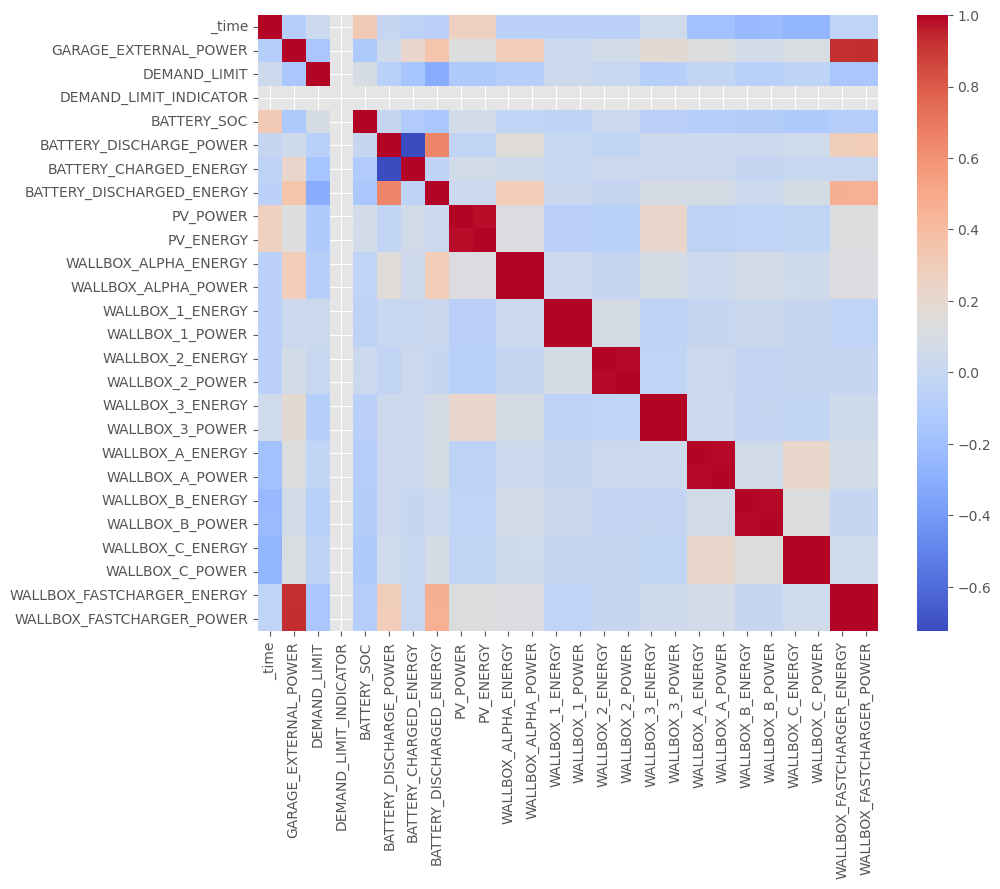

In [21]:
# Calculate the correlation between features
correlation = ds_dynamic.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=False, cmap='coolwarm')

# Show the plot
plt.show()

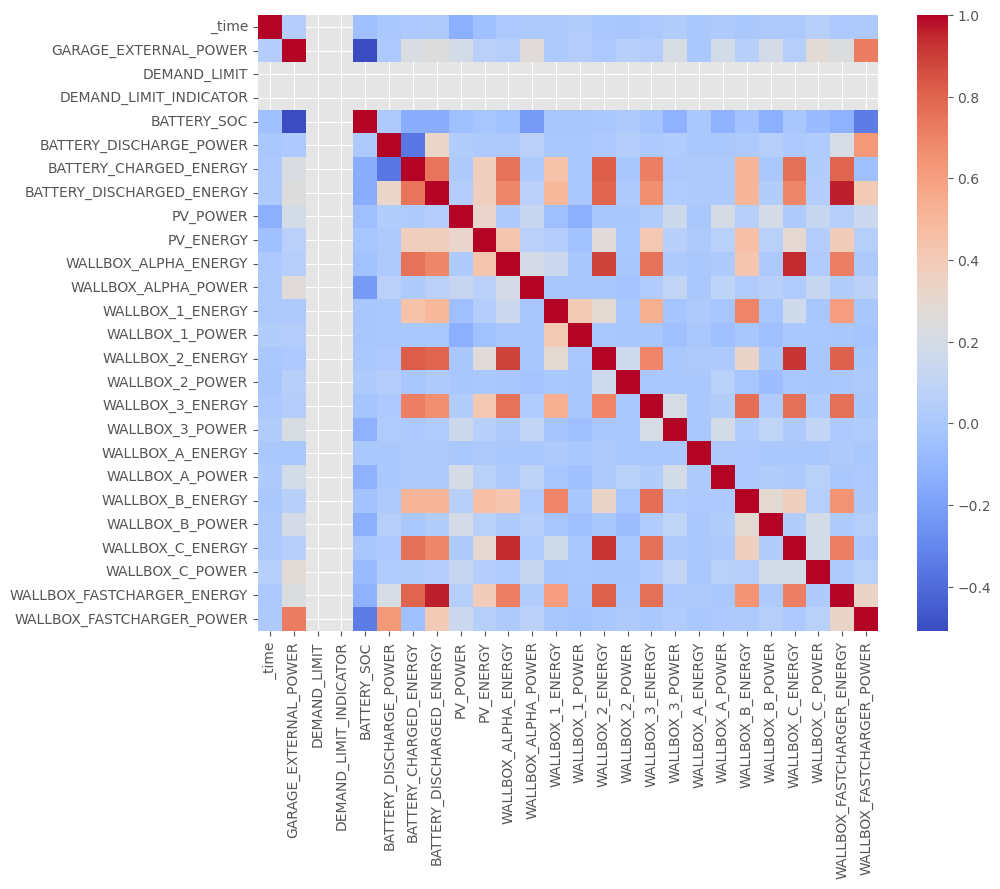

In [22]:
# Calculate the correlation between features
correlation_stat = ds_static.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_stat, annot=False, cmap='coolwarm')

# Show the plot
plt.show()

In [43]:
# list what is strongly correlated with what
correlation_threshold = 0.5
correlation_pairs = {}
for i in correlation.columns:
    for j in correlation.columns:
        if i != j:
            if correlation[i][j] > correlation_threshold:
                correlation_pairs[(i, j)] = correlation[i][j]

In [44]:
correlation_pairs

{('GARAGE_EXTERNAL_POWER', 'WALLBOX_FASTCHARGER_ENERGY'): 0.9247220474847226,
 ('GARAGE_EXTERNAL_POWER', 'WALLBOX_FASTCHARGER_POWER'): 0.9286265153358423,
 ('BATTERY_DISCHARGE_POWER', 'BATTERY_DISCHARGED_ENERGY'): 0.6507976059456484,
 ('BATTERY_DISCHARGED_ENERGY', 'BATTERY_DISCHARGE_POWER'): 0.6507976059456484,
 ('PV_POWER', 'PV_ENERGY'): 0.9857245959022245,
 ('PV_ENERGY', 'PV_POWER'): 0.9857245959022245,
 ('WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER'): 0.9954755345669964,
 ('WALLBOX_ALPHA_POWER', 'WALLBOX_ALPHA_ENERGY'): 0.9954755345669964,
 ('WALLBOX_1_ENERGY', 'WALLBOX_1_POWER'): 0.9950962447978837,
 ('WALLBOX_1_POWER', 'WALLBOX_1_ENERGY'): 0.9950962447978837,
 ('WALLBOX_2_ENERGY', 'WALLBOX_2_POWER'): 0.9931398026927395,
 ('WALLBOX_2_POWER', 'WALLBOX_2_ENERGY'): 0.9931398026927395,
 ('WALLBOX_3_ENERGY', 'WALLBOX_3_POWER'): 0.9968843193784944,
 ('WALLBOX_3_POWER', 'WALLBOX_3_ENERGY'): 0.9968843193784944,
 ('WALLBOX_A_ENERGY', 'WALLBOX_A_POWER'): 0.9923005985930166,
 ('WALLBOX_A_POWE

In [23]:
# Print unique values of DEMAND_LIMIT
print(ds_dynamic['DEMAND_LIMIT'].unique())
print(ds_static['DEMAND_LIMIT'].unique())

[86. 85. 81. 84. 79. 77. 75. 76. 80. 74. 72. 73. 82. 78. 71. 70. 67. 63.
 60. 64. 66. 68. 83. 69. 62. 59. 56. 54. 53. 57. 58. 65. 51. 49. 52. 61.
 55. 50. 48. 45. 46. 47. 39. 40. 42. 43. 44. 41. 36. 34. 35. 33. 37. 38.
 30. 32. 27. 22. 16. 17. 20. 25. 31.]
[50.]


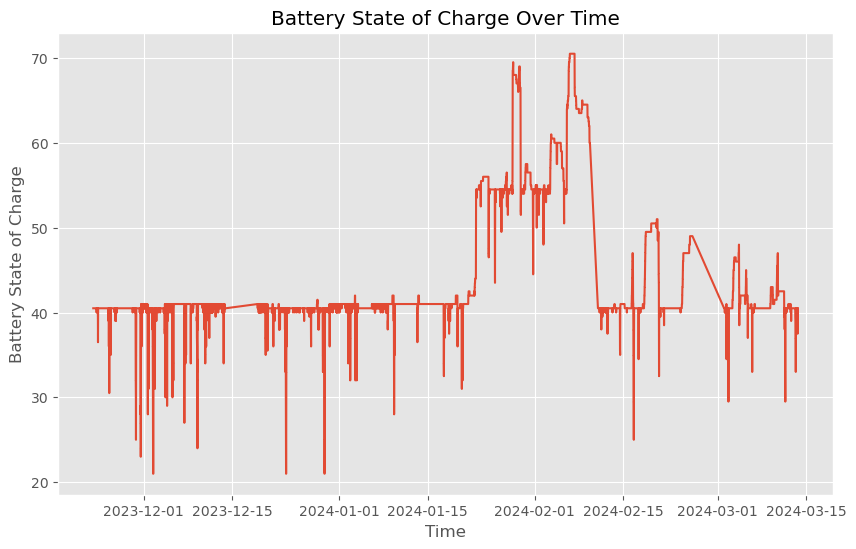

In [25]:


# Plot BATTERY_SOC over time
plt.figure(figsize=(10, 6))
plt.plot(ds_dynamic['_time'], ds_dynamic['BATTERY_SOC'])

plt.title('Battery State of Charge Over Time')
plt.xlabel('Time')
plt.ylabel('Battery State of Charge')

# Show the plot
plt.show()

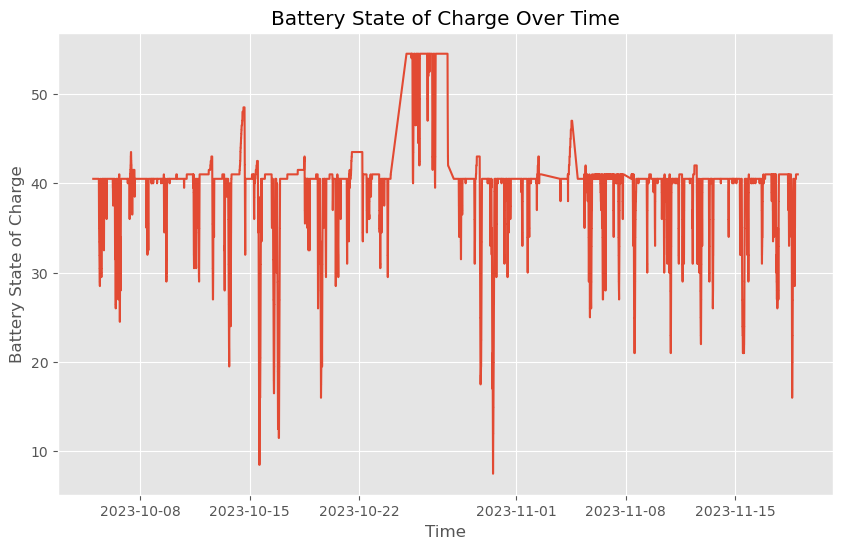

In [26]:


# Plot BATTERY_SOC over time
plt.figure(figsize=(10, 6))
plt.plot(ds_static['_time'], ds_static['BATTERY_SOC'])

plt.title('Battery State of Charge Over Time')
plt.xlabel('Time')
plt.ylabel('Battery State of Charge')

# Show the plot
plt.show()

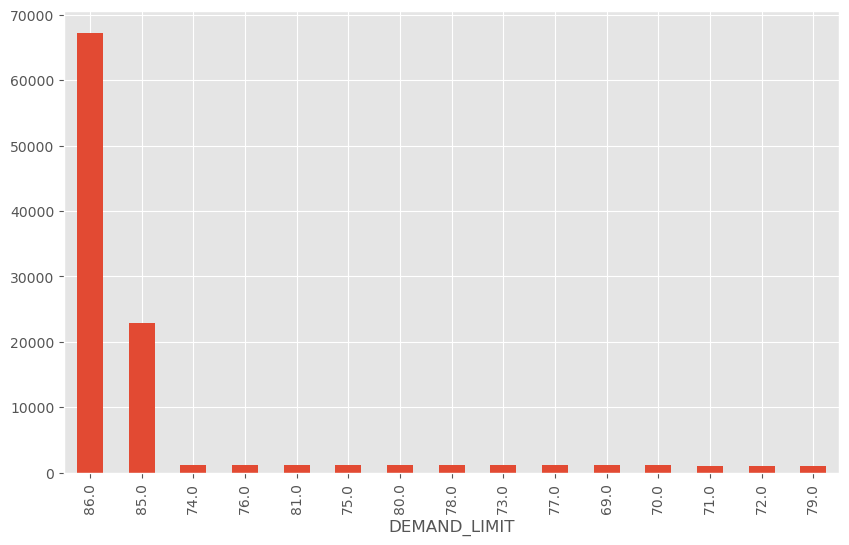

In [80]:
ax = ds_dynamic['DEMAND_LIMIT'].value_counts() \
    .head(15) \
    .plot(kind='bar', figsize=(10, 6))

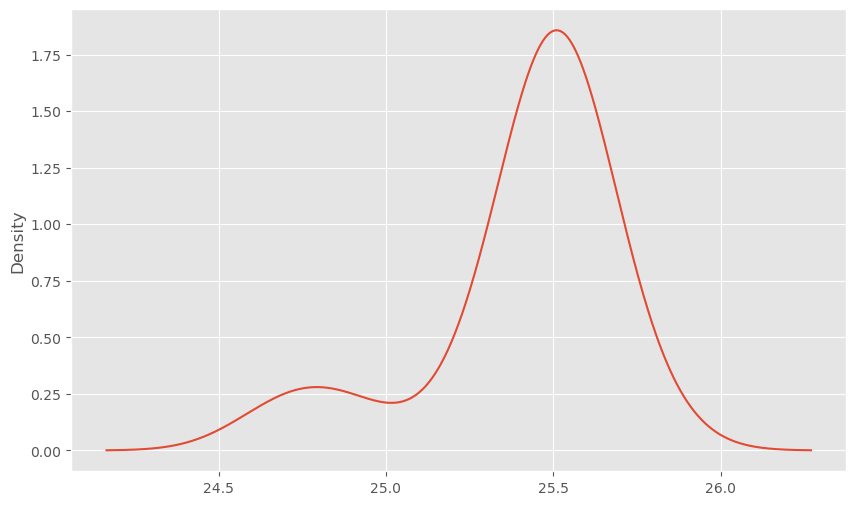

In [83]:
ax = ds_dynamic['GARAGE_EXTERNAL_POWER'] \
    .head(15) \
    .plot(kind='kde', figsize=(10, 6))

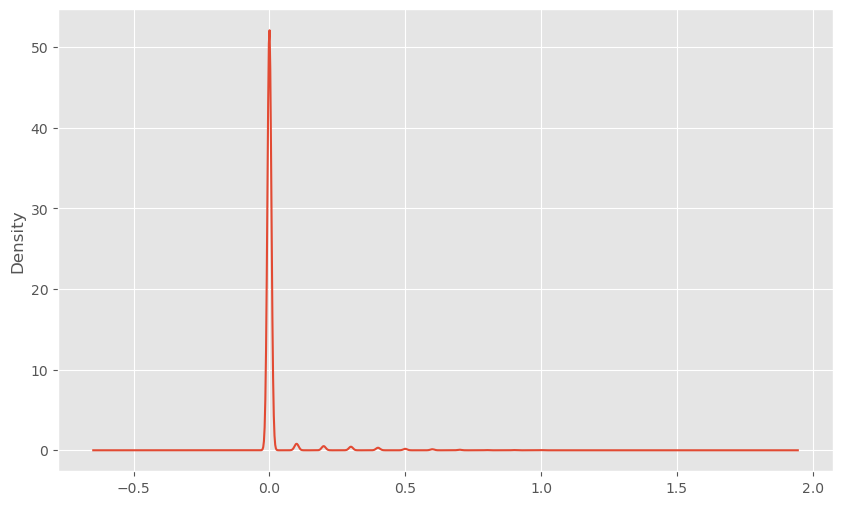

In [36]:
ax = ds_dynamic['BATTERY_DISCHARGED_ENERGY'] \
    .plot(kind='kde', figsize=(10, 6))

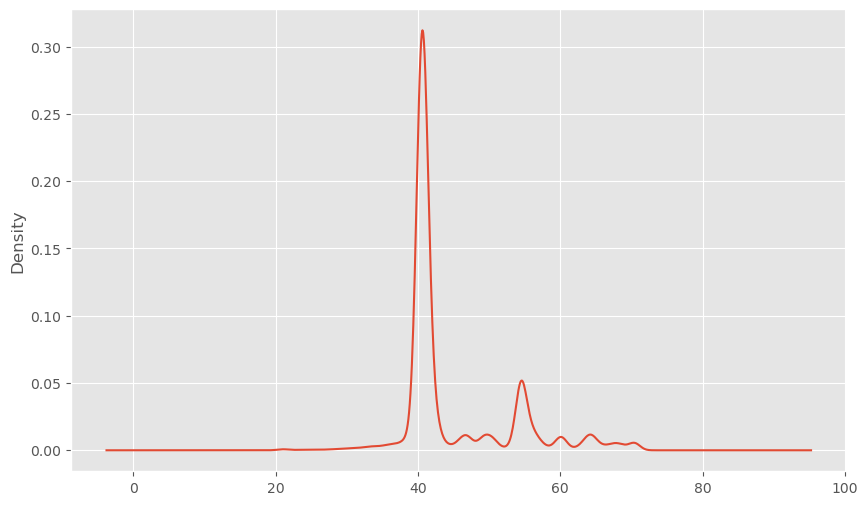

In [38]:
ax = ds_dynamic['BATTERY_SOC'] \
    .plot(kind='kde', figsize=(10, 6))

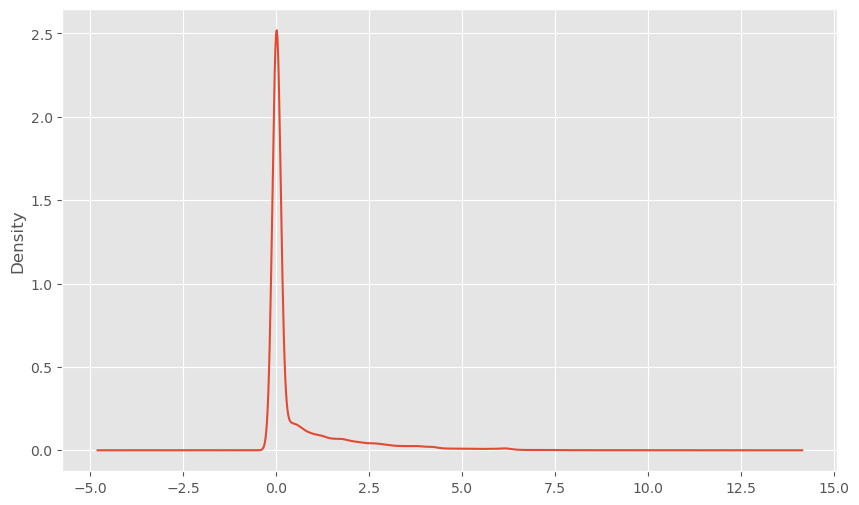

In [42]:
ax = ds_dynamic['PV_POWER'] \
    .plot(kind='kde', figsize=(10, 6))

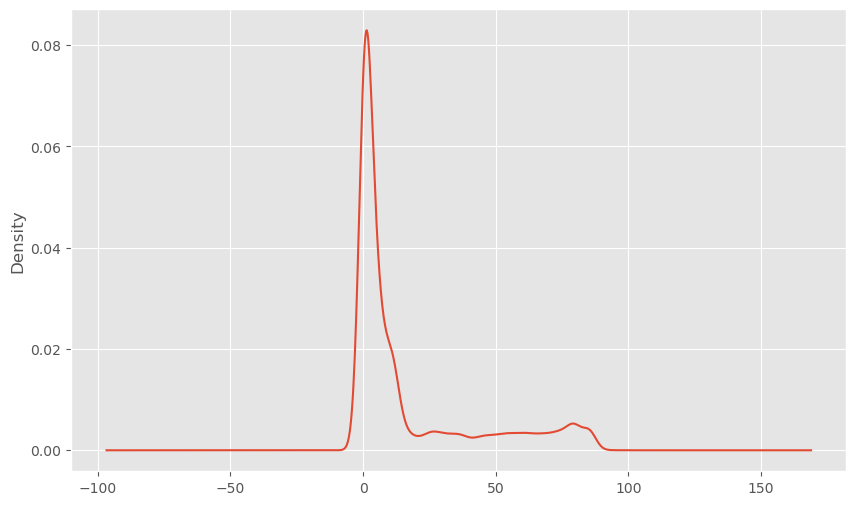

In [59]:
ax = ds_dynamic['GARAGE_EXTERNAL_POWER'] \
    .plot(kind='kde', figsize=(10, 6))

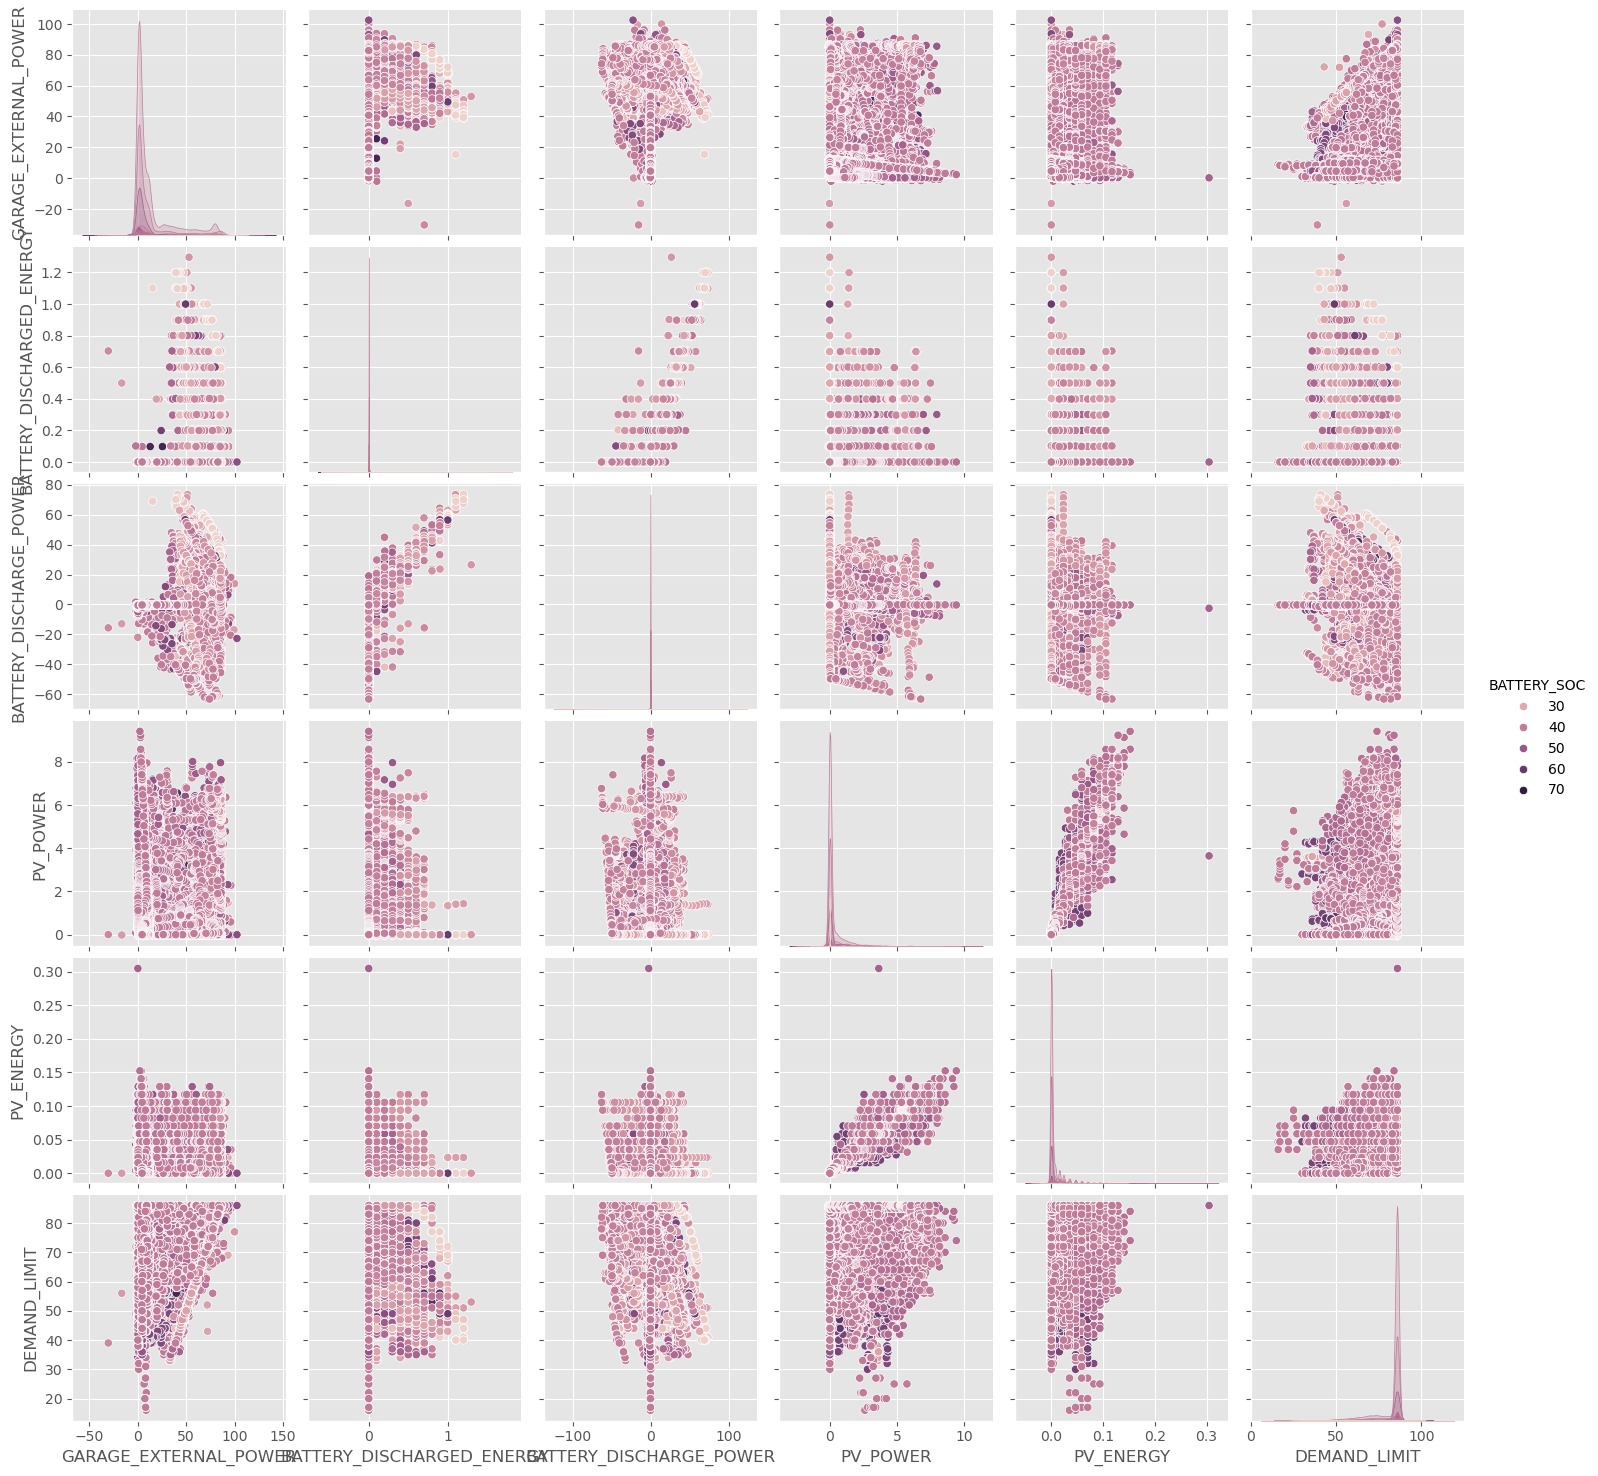

In [58]:
sns.pairplot(ds_dynamic,
             vars=['GARAGE_EXTERNAL_POWER',
                   'BATTERY_DISCHARGED_ENERGY',
                   'BATTERY_DISCHARGE_POWER',
                   'PV_POWER',
                   'PV_ENERGY',
                   'DEMAND_LIMIT'],
            hue='BATTERY_SOC')
plt.show()

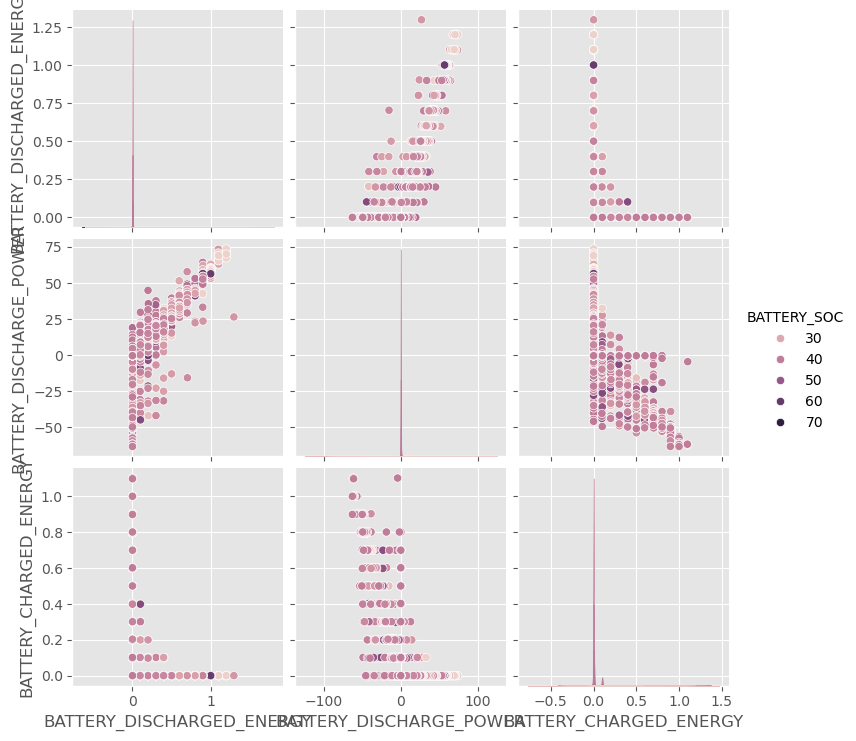

In [4]:
sns.pairplot(ds_dynamic,
             vars=['BATTERY_DISCHARGED_ENERGY',
                   'BATTERY_DISCHARGE_POWER',
                   'BATTERY_CHARGED_ENERGY'],
            hue='BATTERY_SOC')
plt.show()


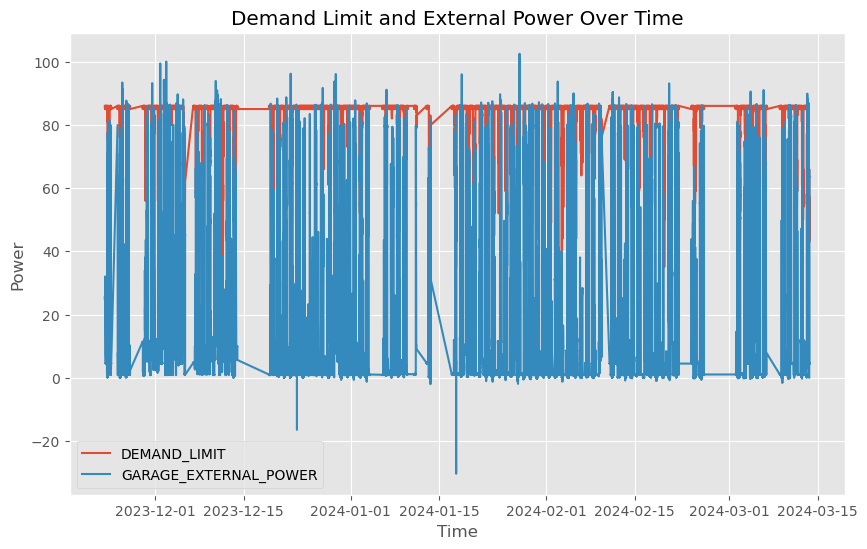

In [63]:

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot DEMAND_LIMIT over time
plt.plot(ds_dynamic['_time'], ds_dynamic['DEMAND_LIMIT'], label='DEMAND_LIMIT')

# Plot GARAGE_EXTERNAL_POWER over time
plt.plot(ds_dynamic['_time'], ds_dynamic['GARAGE_EXTERNAL_POWER'], label='GARAGE_EXTERNAL_POWER')

# Add title and labels
plt.title('Demand Limit and External Power Over Time')
plt.xlabel('Time')
plt.ylabel('Power')

# Add a legend
plt.legend()

# Show the plot
plt.show()

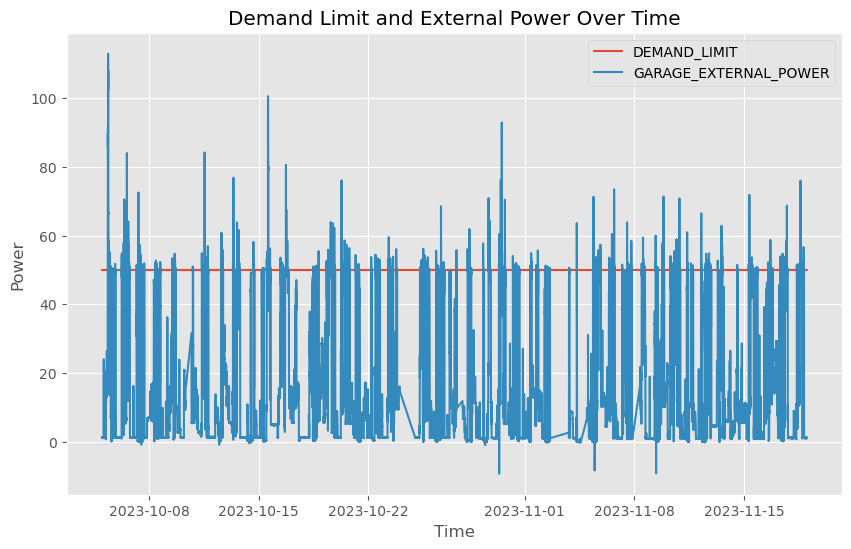

In [64]:

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot DEMAND_LIMIT over time
plt.plot(ds_static['_time'], ds_static['DEMAND_LIMIT'], label='DEMAND_LIMIT')

# Plot GARAGE_EXTERNAL_POWER over time
plt.plot(ds_static['_time'], ds_static['GARAGE_EXTERNAL_POWER'], label='GARAGE_EXTERNAL_POWER')

# Add title and labels
plt.title('Demand Limit and External Power Over Time')
plt.xlabel('Time')
plt.ylabel('Power')

# Add a legend
plt.legend()

# Show the plot
plt.show()